# plot a field from the POP model at multiple time steps in a loop using `dask.delayed`

In [1]:
%matplotlib inline
import os
from subprocess import call
from glob import glob

from datetime import datetime
import time

import xarray as xr
import numpy as np
import dask
import dask.distributed

import ncar_jobqueue

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

import plot_tools as pt

os.environ['CARTOPY_USER_BACKGROUNDS'] = '/glade/work/mclong/cartopy-background-img'

## spin up a dask cluster

In [2]:
cluster = ncar_jobqueue.NCARCluster(cores=18,
                                    processes=18)
client = dask.distributed.Client(cluster)
n_workers = 18 * 2
cluster.scale(n_workers)

/glade/work/mclong/miniconda3/envs/analysis/lib/python3.7/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


In [3]:
!qstat | grep dask-worker

/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_module'
/usr/bin/sh: ml: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_ml'
4995357.chadmin1  dask-worker      mclong            00:01:37 R regular         
4995358.chadmin1  dask-worker      mclong            00:01:30 R regular         
4995359.chadmin1  dask-worker      mclong            00:01:31 R regular         
4995360.chadmin1  dask-worker      mclong            00:01:35 R regular         
4995523.chadmin1  dask-worker      mclong                   0 Q regular         


In [18]:
client

Client Scheduler: tcp://10.148.10.15:39057 Dashboard: http://10.148.10.15/proxy/45594/status,Cluster Workers: 36 Cores: 36 Memory: 218.16 GB


## plotting functions
Define a function to fix the plot grid for plotting global maps; this might not be necessary for regional plots, depending on the region.

In [5]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    field = np.ma.masked_where(np.isnan(field),field)

    return lon,lat,field

Define a bespoke plot function to be called in loop

In [12]:
var = 'pCO2SURF'
figpath = f'fig/hires-animation/{var}'
os.makedirs(figpath, exist_ok=True)

    
def plot(file_in,i,clobber=True,close=True):

    coords = {'x':'TLONG','y':'TLAT'}
    keep_vars = [var]+list(coords.values())+['dz','KMT']

    cmap = cmocean.cm.delta
    if var == 'KE':
        convert_units = 1e-4
        units = 'm$^2$ s$^{-2}$'
        pclr_specs = {'norm': colors.LogNorm(vmin=1e-4, vmax=0.5)}
        
    elif var == 'NPP':
        convert_units = 1e-9 * 1e4 * 86400.
        units = 'mmol m$^{-2}$ d$^{-2}$'
        pclr_specs = {'norm': colors.LogNorm(vmin=1e-2, vmax=1e0)}

    elif var == 'pCO2SURF':
        convert_units = 1.
        units = 'ppm'
        pclr_specs = {'vmin': 180., 'vmax': 380}
    else:
        raise ValueError(f'unknown variable: {var}')
    
    plot_name = f'{figpath}/{i:03d}.png'
    if os.path.exists(plot_name) and not clobber:
        return 
    
    from matplotlib.axes import Axes
    from cartopy.mpl.geoaxes import GeoAxes
    GeoAxes._pcolormesh_patched = Axes.pcolormesh

    datestr = file_in[file_in.find('h.')+2:file_in.find('h.')+12]
    
    
    with xr.open_dataset(file_in,decode_times=False,decode_coords=False) as ds:
        
        if var == 'NPP':
            ds['NPP'] = (ds.photoC_sp + ds.photoC_diat + ds.photoC_diaz).isel(time=0)
           
        ds = ds.drop([v for v in ds.variables if v not in keep_vars])
        
        if var == 'KE':
            ds = ds.isel(time=0).isel(z_t=slice(0,10)).mean('z_t')

        elif var == 'NPP':
            dz_z_t_150m = ds.dz.isel(z_t=slice(0,15)).rename({'z_t':'z_t_150m'})
            ds['NPP'] = (ds.NPP * dz_z_t_150m).sum('z_t_150m')
            ds['NPP'] = ds['NPP'].where(ds.NPP > 0.).fillna(1e-6).where(ds.KMT>0)

        elif var == 'pCO2SURF':
            ds = ds.isel(time=0)
            
        lon,lat,field = adjust_pop_grid(ds[coords['x']].values,
                                        ds[coords['y']].values,
                                        ds[var].values*convert_units)

    
    fig = plt.figure(figsize=(11,10))

    axs = []

    ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
    ax.set_extent([-180, 180, -90, -35], ccrs.PlateCarree())
    
    ax.background_img('natural-earth-1-no-ocean',resolution='large4096px')
    #ax.background_img('nasa-bluemarble-topo-2004-01',resolution='large')
    pc = ax.pcolormesh(lon, lat, field,
                       cmap=cmap,
                       transform=ccrs.PlateCarree(), 
                       **pclr_specs)
    
    ax.set_rasterization_zorder(2)
    pc.set_rasterized(True)
    pc.set_zorder(1)
    ax.coastlines('10m',linewidth=0.5,zorder=10)
    
    ax.set_title(datestr,loc='right')
    
    axs.append(ax)
   
    plt.subplots_adjust(right=0.9)

    ptop = axs[0].get_position()
    pbot = axs[-1].get_position()

    height = ptop.y0 + ptop.height - pbot.y0
    cbar_height = 0.35
    y0 = pbot.y0+height/2-cbar_height/2 

    cax = plt.axes((0.92,y0,0.015,cbar_height))
    cax.set_title(units,loc='left')
    plt.colorbar(pc,cax=cax)    
 
    if close:
        fig.savefig(plot_name,dpi=300,bbox_inches='tight')
        plt.close()
    
    return

## search for files

In [13]:
case = 'g.e11.G.T62_t12.eco.006'
droot = f'/glade/scratch/mclong/hi-res-eco/{case}/ocn/hist'
files = sorted(glob(f'{droot}/{case}.pop.h.????-??-??.nc'))
len(files)

365

## loop over files and plot each

Sample plot

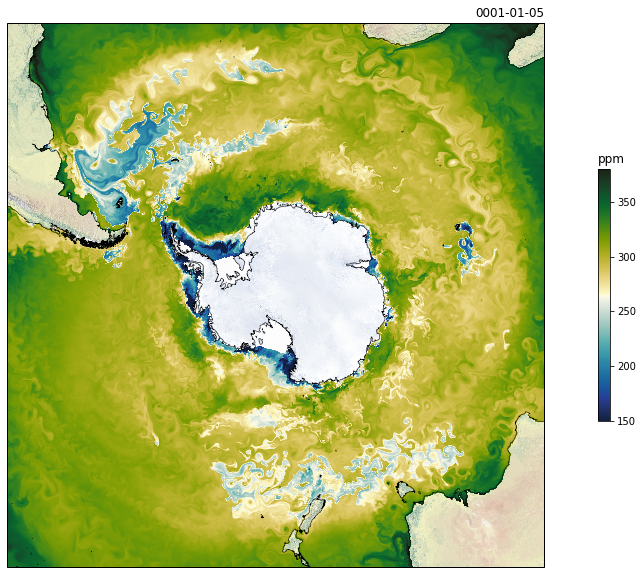

In [8]:
plot(files[0], 0, close=False)

Call `plot` in loop using `dask.delayed`

In [19]:
clobber = True
results = []
for i in range(len(files)):
    figo = dask.delayed(plot,pure=True)(files[i],i,clobber=clobber)
    results.append(figo)

Call compute to execute plotting

In [ ]:
%%time
results = dask.compute(*results) 

In [16]:
cluster.close()

RuntimeError: Command exited with non-zero exit code.
Exit code: 35
Command:
qdel 4995524 4995523
stdout:

stderr:
qdel: Job has finished
qdel: Job has finished

